# Analysis of dumps
## Raw Data
The test suite stores tcpdump output in a json format. Because this contains information about each packet, it can be parsed to determine information that would not normally be revealed by the transfer program itself. For example, how much overhead or compression there was.

In [1]:
from helpers import get_dump_fnames, get_dumps, organize_dumps

PROTOCOLS = ["scp", "hpn-scp", "ftp", "gridftp"]
N = None # The number of records to retrieve (None=all)

# Find the relevant dumps
names = get_dump_fnames(PROTOCOLS, N)
dumps = get_dumps(names)

# Fetch relevant columns and rename them
df, ids = organize_dumps(dumps)

In [2]:
df

,Protocol,Batch ID,Stored Packets,Start Time,File Size (bytes),Bytes Down,Bytes Up,Bytes Total,Ratio (%),Time (s),Speed (bytes/s)
0,ftp,19,False,2015-10-14 09:16:55,536870912,538075425,1314635,539390060,100.47,24.81,21687844.62
1,ftp,30,False,2015-10-14 09:54:05,536870912,538162641,1310467,539473108,100.48,26.61,20224075.20
2,ftp,26,False,2015-10-14 10:29:44,536870912,537954105,1287083,539241188,100.44,25.78,20867110.36
3,ftp,29,False,2015-10-14 11:31:06,536870912,533989129,1233059,535222188,99.69,53.56,9969923.99
4,ftp,17,False,2015-10-14 11:58:22,536870912,517428625,1139819,518568444,96.59,60.48,8555367.48
5,ftp,24,False,2015-10-14 12:19:56,536870912,531730337,1170931,532901268,99.26,49.23,10800941.24
6,ftp,22,False,2015-10-14 09:19:32,1073741824,1076217465,2524643,1078742108,100.47,46.17,23309886.61
7,ftp,3,False,2015-10-14 09:56:42,1073741824,1035847689,2475939,1038323628,96.70,50.21,20630306.49
8,ftp,2,False,2015-10-14 10:32:22,1073741824,1076348865,2535019,1078883884,100.48,45.11,23860537.91
9,ftp,12,False,2015-10-14 11:07:16,1073741824,443724353,1934760,445659113,41.51,20.63,21508693.80


## Remove outliers
The data doesn't tend to have outliers for large filesizes, but with file less than 10Mb there can be some anomalies

In [3]:
sel = df[df["File Size (bytes)"] < 10000000] # Choose everything less than 10Mb
# If the ratio of filesize to packets is more than 1 million, there is a problem
outliers = sel[sel["Bytes Total"]/sel["File Size (bytes)"] > 1000000]

# Remove only those lines. For now, leave the rest of the batch
df.drop(outliers.index, inplace=True)

## Aggregate Data
The table above can be aggregated per filesize and protocol, then displayed visually.

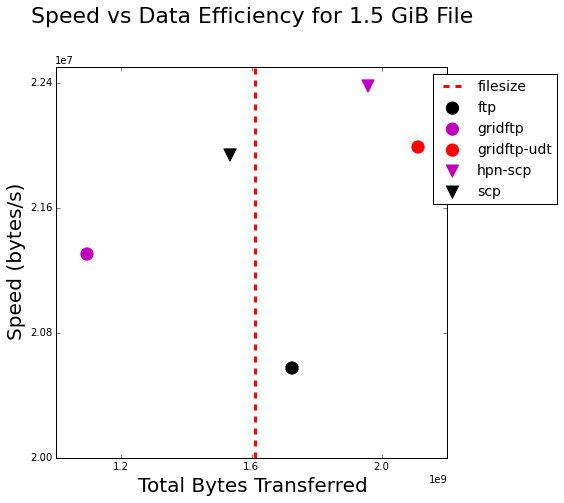

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from ipywidgets import interact, fixed
import numpy as np
import pandas as pd

from plot import plot_speed_efficiency

rcParams['figure.figsize'] = (7, 7)

# Group by Filesize and then Protocol
agg = df.groupby(["File Size (bytes)", "Protocol"]).aggregate(np.mean)
agg.drop(["Batch ID", "Stored Packets"], axis=1, inplace=True)

sizes = {str(x):x for x in set(df["File Size (bytes)"])}
agg_interact = interact(plot_speed_efficiency, df=fixed(agg), filesize=sizes)

In [10]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# print agg.reset_index().to_latex()
agg

Bytes Down   Bytes Up  Bytes Total  Ratio (%)  \
File Size (bytes) Protocol                                                      
5242880           ftp            4584586.6    13931.0    4598517.6       87.7   
                  gridftp        5241199.7     4423.0    5245622.7      100.0   
                  gridftp-udt    6048924.3     6487.7    6055412.0      115.5   
                  hpn-scp        4448937.0 20484496.8   24933433.8      475.6   
                  scp            4663665.0     5249.7    4668914.7       89.1   
536870912         ftp          532890043.7  1242665.7  534132709.3       99.5   
                  gridftp      535416759.0     4491.0  535421250.0       99.7   
                  gridftp-udt  769127304.0   680060.0  769807364.0      143.4   
                  hpn-scp      428268275.2   138198.8  428406474.0       79.8   
                  scp          519956681.0   195382.2  520152063.2       96.9   
1073741824        ftp         1010076445.0  2194429.2 1012270874.2       94.3   
                  gridftp     1396949321.2   595564.0 1397544885.2      130.2   
                  gridftp-udt 1542116080.2   507444.6 1542623524.8      143.7   
                  hpn-scp     1239695701.8   320474.2 1240016176.0      115.5   
                  scp         1334123367.7   396697.7 1334520065.3      124.3   
1610612736        ftp         1719626658.3  3332315.7 1722958974.0      107.0   
                  gridftp     1093916352.8    19292.8 1093935645.6       67.9   
                  gridftp-udt 2108399993.5  1608599.0 2110008592.5      131.0   
                  hpn-scp     1956827636.0   644424.0 1957472060.0      121.5   
                  scp         1532684254.3   723116.3 1533407370.7       95.2   
2147479552        ftp         2091098148.4  4399623.7 2095497772.1       97.6   
                  gridftp     2263222261.6   142771.8 2263365033.4      105.4   
                  gridftp-udt 2302639931.9  1016533.9 2303656465.7      107.3   
                  hpn-scp     1681500086.0   703475.5 1682203561.5       78.3   
                  scp         1862956947.7   994940.0 1863951887.7       86.8   

                               Time (s)  Speed (bytes/s)  
File Size (bytes) Protocol                                
5242880           ftp               1.6        2982436.0  
                  gridftp           1.8        3070321.5  
                  gridftp-udt       4.0        1711681.3  
                  hpn-scp           1.2        4123426.5  
                  scp               1.1        4530599.3  
536870912         ftp              40.1       15350877.1  
                  gridftp          35.2       18355782.0  
                  gridftp-udt      36.4       21037422.5  
                  hpn-scp          19.3       23077755.2  
                  scp              30.1       19500374.9  
1073741824        ftp              46.5       21742098.3  
                  gridftp       -5938.2       18361368.2  
                  gridftp-udt      70.5       21982332.1  
                  hpn-scp          57.1       21632349.6  
                  scp              62.7       21650585.1  
1610612736        ftp              79.8       20572344.8  
                  gridftp          50.3       21307476.4  
                  gridftp-udt      95.3       21986425.4  
                  hpn-scp          88.4       22382538.2  
                  scp              70.1       21938285.4  
2147479552        ftp             103.0       20638761.1  
                  gridftp         109.5       20039391.9  
                  gridftp-udt     105.7       21830917.7  
                  hpn-scp          79.9       20216284.5  
                  scp              86.0       21576296.2

## Metrics per filesize
The above data can also be shown as two separate graphs, as a function of filesize.

## Speed

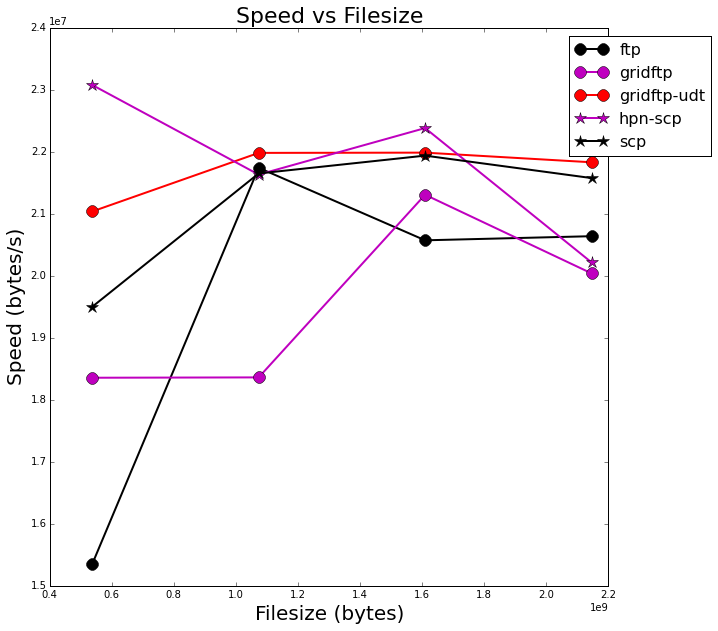

In [11]:
%matplotlib inline
from plot import plot_speed_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_speed_per_filesize(df, ratio=False, ignore_small=True)

## Data Usage

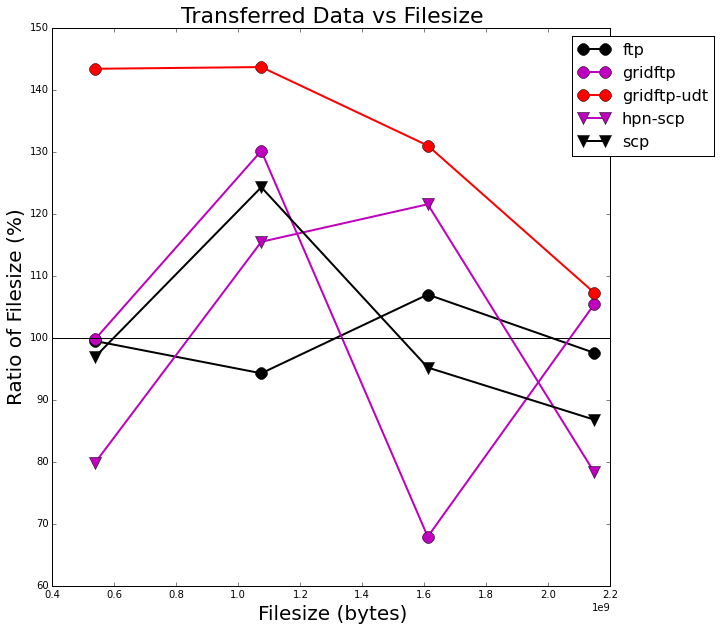

In [12]:
%matplotlib inline
from plot import plot_data_per_filesize

rcParams['figure.figsize'] = (10, 10)

plot_data_per_filesize(df, ignore_small=True)

## Topography of Transfer
Displaying the packet sizes against a time axis gives more insight into each protocol. It's also a good representation of network conditions, as breaks or delays are easily seen.

In [14]:
%matplotlib inline
import warnings

from plot import plot_packets

warnings.simplefilter('ignore', UserWarning)
rcParams['figure.figsize'] = (12, 12)

def reverse_lookup(bid):
    for key, val in ids.items():
        if val == bid:
            return key
    return None

batch_ids = {str(x):reverse_lookup(x) for x in set(df[df["Stored Packets"]]["Batch ID"])}
if batch_ids:
    packet_interact = interact(plot_packets, batch_id=batch_ids)
else:
    print "No batches captured with '--store-packets' found"

No batches captured with '--store-packets' found
